In [1]:
import os
import pandas as pd
import numpy as np
from numpy import var, mean, sqrt
import pyfaidx
import pysam
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

In [2]:
MUT_DATA = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
TFBS_DATA = "../data/TFBS_data_diff"
REF_FASTA = "../data/ref/hg19.fa"
DRIVER_GENES_PANCAN = "../data/datasets/driver_genes_intogen/Pancancer.tsv"

RESULTS_DIR = "../results/TFBS_diff"

if not os.path.exists(RESULTS_DIR):
	os.makedirs(RESULTS_DIR)

# Fasta sequence extractor
pyfaidx.Faidx(REF_FASTA)
REF_GENOME_OPEN = pysam.Fastafile(REF_FASTA) 

CANCER_TYPES = os.listdir(DRIVER_GENES) # all cancer types
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [3]:
pancan_driver_genes = pd.read_csv(DRIVER_GENES_PANCAN, sep="\t")
pancan_driver_genes = pancan_driver_genes[["Symbol", "Samples (%)"]]
pancan_driver_genes = pancan_driver_genes[pancan_driver_genes["Samples (%)"] >= 1]
print(pancan_driver_genes.shape)
driver_genes_list = pancan_driver_genes["Symbol"].tolist()

(31, 2)


In [4]:
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:	
	mut_cancer_df = pd.read_csv(f"{MUT_DATA}/{cancer_type}.tsv", sep="\t")
	mut_cancer_df = mut_cancer_df[["Tumor_Sample_Barcode", "mutation", "gene", "driver", "has_driver", "genic_region"]]
	mut_cancer_df["cancer_type"] = cancer_type

	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	mut_cancer_df = mut_cancer_df[mut_cancer_df["gene"].isin(driver_genes_list)]
	mut_df = pd.concat([mut_df, mut_cancer_df], axis=0)

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)
mut_df.head()

,Tumor_Sample_Barcode,mutation,gene,driver,has_driver,genic_region,cancer_type,driver_status
18,00493087-9d9d-40ca-86d5-936f1b951c93,1:78425869-78425869:C:G,FUBP1,True,True,exonic,CNS-Oligo,Drivers
914,00493087-9d9d-40ca-86d5-936f1b951c93,19:42791826-42791826:T:C,CIC,True,True,exonic,CNS-Oligo,Drivers
915,00493087-9d9d-40ca-86d5-936f1b951c93,19:42798878-42798878:T:G,CIC,True,True,exonic,CNS-Oligo,Drivers
1083,00493087-9d9d-40ca-86d5-936f1b951c93,2:209113112-209113112:C:T,IDH1,True,True,exonic,CNS-Oligo,Drivers
3841,2aeaab9f-4459-4be8-91e7-e0746cbd671c,17:7574012-7574012:C:A,TP53,True,True,exonic,CNS-Oligo,Drivers


In [5]:
def get_key(mutation):
	'''
	Generate a key to match the mutation format for TFBS data
	Used to merge the two dataframes on the mutation
	'''
	chrom, pos, ref, alt = mutation.split(":")
	pos = pos.split("-")[0]
	# using 0-based indexing for pysam fetch
	start = int(pos)-1
	end = int(pos)
	# include the previous base in case of indels and MNVs
	if ref == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		pos = int(pos) - 1
	elif alt == "-":
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start)
		pos = int(pos) - 1
	elif len(ref) > 1 or len(alt) > 1:
		ref = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, end)
		alt = REF_GENOME_OPEN.fetch(f"chr{chrom}", start-1, start) + alt
		pos = int(pos) - 1
	key = f"chr{chrom}:{pos}{ref}>{alt}"
	return key

# add variant column to use as key for TFBS data
mut_df["variant"] = mut_df["mutation"].apply(get_key)
mut_df.head()


,Tumor_Sample_Barcode,mutation,gene,driver,has_driver,genic_region,cancer_type,driver_status,variant
18,00493087-9d9d-40ca-86d5-936f1b951c93,1:78425869-78425869:C:G,FUBP1,True,True,exonic,CNS-Oligo,Drivers,chr1:78425869C>G
914,00493087-9d9d-40ca-86d5-936f1b951c93,19:42791826-42791826:T:C,CIC,True,True,exonic,CNS-Oligo,Drivers,chr19:42791826T>C
915,00493087-9d9d-40ca-86d5-936f1b951c93,19:42798878-42798878:T:G,CIC,True,True,exonic,CNS-Oligo,Drivers,chr19:42798878T>G
1083,00493087-9d9d-40ca-86d5-936f1b951c93,2:209113112-209113112:C:T,IDH1,True,True,exonic,CNS-Oligo,Drivers,chr2:209113112C>T
3841,2aeaab9f-4459-4be8-91e7-e0746cbd671c,17:7574012-7574012:C:A,TP53,True,True,exonic,CNS-Oligo,Drivers,chr17:7574012C>A


In [11]:
# TFBS data
tfbs_data_file = f"{TFBS_DATA}/all_variants.tsv"
if os.path.exists(tfbs_data_file):
	tfbs_df = pd.read_csv(tfbs_data_file, sep="\t")
else:
	tfbs_df = pd.DataFrame()
	for cancer_type in CANCER_TYPES:
		tf_cancer_file = f"{TFBS_DATA}/{cancer_type}.tsv"
		if not os.path.exists(tf_cancer_file):
			print(f"TFBS data file not found for {cancer_type}")
			continue
		tfbs_cancer_df = pd.read_csv(f"{TFBS_DATA}/{cancer_type}.tsv", sep="\t")
		tfbs_cancer_df = tfbs_cancer_df[["variant", "tf", "score"]]
		tfbs_df = pd.concat([tfbs_df, tfbs_cancer_df], axis=0)
	# remove duplicates
	tfbs_df = tfbs_df.drop_duplicates(subset=["variant", "tf"])
	tfbs_df["variant_tf"] = tfbs_df["variant"] + "_" + tfbs_df["tf"]
	tfbs_df.to_csv(tfbs_data_file, sep="\t", index=False)
tfbs_var_dict = tfbs_df.set_index("variant_tf")["score"].to_dict()
tfbs_df.head()

,variant,tf,score,variant_tf
0,chr17:7574012C>A,A1CF,0.026700,chr17:7574012C>A_A1CF
1,chr17:7574012C>A,AHR,0.004375,chr17:7574012C>A_AHR
2,chr17:7574012C>A,AIRE,-0.063350,chr17:7574012C>A_AIRE
3,chr17:7574012C>A,ALX1,0.011750,chr17:7574012C>A_ALX1
4,chr17:7574012C>A,ALX3,0.044150,chr17:7574012C>A_ALX3


In [12]:
mut_tf_df = mut_df[["Tumor_Sample_Barcode", "variant", "gene", "driver_status", "genic_region", "cancer_type"]].copy()
mut_tf_df = mut_tf_df[mut_tf_df["genic_region"] == "upstream"]
print(mut_tf_df.shape)
mut_tf_df.drop_duplicates(inplace=True)
print(mut_tf_df.shape)
mut_tf_df.head()

(423, 6)
(423, 6)


,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region,cancer_type
698744,79914ce9-04d8-4b0d-9f16-2e528044966e,chr7:152133417G>A,KMT2C,Passengers in absence of driver,upstream,Prost-AdenoCA
490392,cbb788dd-964b-4cfd-80e1-979c7b5b3c52,chr4:187645995G>T,FAT1,Passengers in absence of driver,upstream,Kidney-RCC
653596,1e046ab9-fa4c-4c15-8d78-ed0048c80ebf,chr3:10182858A>G,VHL,Passengers in presence of driver,upstream,Kidney-RCC
908767,bef23192-57cd-4301-b7a7-5e82ca62482d,chr7:116312044G>T,MET,Passengers in absence of driver,upstream,Kidney-RCC
13765,1a391468-fbf3-451a-b88e-a257a26d047f,chr3:41240921C>T,CTNNB1,Passengers in absence of driver,upstream,Stomach-AdenoCA


In [13]:
def cohen_d(x, y):
    # size of samples
    n1, n2 = len(x), len(y)
    # variance of the samples
    s1, s2 = var(x, ddof=1), var(y, ddof=1)
    # pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # means of the samples
    u1, u2 = mean(x), mean(y)
    # return the effect size
    return (u1 - u2) / s

In [14]:
tf_diff = []
tfs = tfbs_df["tf"].unique().tolist()
mut_tf_data = pd.DataFrame()
for tf in tfs:
	mut_data_df = mut_tf_df.copy()
	mut_data_df["tf"] = tf
	mut_data_df["score"] = mut_data_df.apply(lambda x: tfbs_var_dict.get(f"{x['variant']}_{tf}", 0), axis=1).astype(float)
	mut_data_df["abs_score"] = mut_data_df["score"].abs()
	mut_data_df["prediction"] = mut_data_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
	mut_data_df["prediction"] = mut_data_df["prediction"].apply(lambda x: "no change" if x == 0 else x)
	mut_tf_data = pd.concat([mut_tf_data, mut_data_df], axis=0)
mut_tf_data.reset_index(drop=True, inplace=True)
print(mut_tf_data.shape)
mut_tf_data.head()

(586701, 10)


,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region,cancer_type,tf,score,abs_score,prediction
0,79914ce9-04d8-4b0d-9f16-2e528044966e,chr7:152133417G>A,KMT2C,Passengers in absence of driver,upstream,Prost-AdenoCA,A1CF,-0.1585,0.1585,loss
1,cbb788dd-964b-4cfd-80e1-979c7b5b3c52,chr4:187645995G>T,FAT1,Passengers in absence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
2,1e046ab9-fa4c-4c15-8d78-ed0048c80ebf,chr3:10182858A>G,VHL,Passengers in presence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
3,bef23192-57cd-4301-b7a7-5e82ca62482d,chr7:116312044G>T,MET,Passengers in absence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
4,1a391468-fbf3-451a-b88e-a257a26d047f,chr3:41240921C>T,CTNNB1,Passengers in absence of driver,upstream,Stomach-AdenoCA,A1CF,0.0303,0.0303,gain


In [15]:
# gene = "FBXW7"
# plot_data = mut_tf_data[mut_tf_data["gene"] == gene]
plot_data = mut_tf_data[mut_tf_data["driver_status"] != "Drivers"]
print(plot_data.shape)
plot_data

(406391, 10)


,Tumor_Sample_Barcode,variant,gene,driver_status,genic_region,cancer_type,tf,score,abs_score,prediction
0,79914ce9-04d8-4b0d-9f16-2e528044966e,chr7:152133417G>A,KMT2C,Passengers in absence of driver,upstream,Prost-AdenoCA,A1CF,-0.1585,0.1585,loss
1,cbb788dd-964b-4cfd-80e1-979c7b5b3c52,chr4:187645995G>T,FAT1,Passengers in absence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
2,1e046ab9-fa4c-4c15-8d78-ed0048c80ebf,chr3:10182858A>G,VHL,Passengers in presence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
3,bef23192-57cd-4301-b7a7-5e82ca62482d,chr7:116312044G>T,MET,Passengers in absence of driver,upstream,Kidney-RCC,A1CF,0.0000,0.0000,loss
4,1a391468-fbf3-451a-b88e-a257a26d047f,chr3:41240921C>T,CTNNB1,Passengers in absence of driver,upstream,Stomach-AdenoCA,A1CF,0.0303,0.0303,gain
...,...,...,...,...,...,...,...,...,...,...
586696,950486ad-14f8-480a-b079-9cc3cd842090,chr8:114449785G>A,CSMD3,Passengers in absence of driver,upstream,Uterus-AdenoCA,SMPX,-0.0249,0.0249,loss
586697,bcf858fd-cc3b-4fde-ab10-eb96216f4366,chr8:114449359C>A,CSMD3,Passengers in absence of driver,upstream,Uterus-AdenoCA,SMPX,0.0352,0.0352,gain
586698,bcf858fd-cc3b-4fde-ab10-eb96216f4366,chr8:114449525G>A,CSMD3,Passengers in absence of driver,upstream,Uterus-AdenoCA,SMPX,0.0000,0.0000,loss
586699,c082dc34-457e-40ec-8258-e11e8ed362c2,chr7:91569791C>CG,AKAP9,Passengers in absence of driver,upstream,Uterus-AdenoCA,SMPX,0.0000,0.0000,loss


In [16]:
# Group by TF and condition to get list of scores
grouped = plot_data.groupby(['tf', 'driver_status'])['abs_score'].apply(list).unstack()

# Compute statistics
results = []
for tf in grouped.index:
    group1 = grouped.loc[tf, 'Passengers in absence of driver']
    group2 = grouped.loc[tf, 'Passengers in presence of driver']
    stat, pval = ttest_ind(group1, group2, equal_var=False)
    diff = np.mean(group1) - np.mean(group2)
    results.append({'tf': tf, 'p_val': pval, 'diff': diff})
    
volcano_df = pd.DataFrame(results)
volcano_df.dropna(inplace=True) 
volcano_df["log_p"] = volcano_df["p_val"].apply(lambda x: -np.log10(x))
# multiple testing correction
rejected, pvals_corrected, _, _ = multipletests(volcano_df['p_val'], method='fdr_bh')
volcano_df['pval_adj'] = pvals_corrected
volcano_df["log_p_adj"] = volcano_df["pval_adj"].apply(lambda x: -np.log10(x))
volcano_df["direction"] = volcano_df["diff"].apply(lambda x: "Larger effects in\nabsence of driver" if x > 0 else "Larger effects in\npresence of driver")

# count number of TFs with significant p-values
num_significant = len(volcano_df[volcano_df["pval_adj"] < 0.05])
print(f"Number of TFs with significant p-values: {num_significant}")
num_non_significant = len(volcano_df[volcano_df["pval_adj"] >= 0.05])
print(f"Number of TFs without significant p-values: {num_non_significant}")

Number of TFs with significant p-values: 107
Number of TFs without significant p-values: 1280


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_94205/2367923351.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


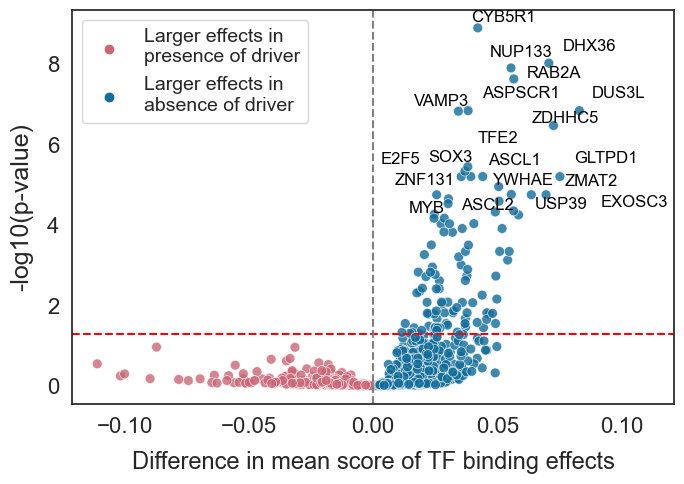

In [17]:
plt.figure(figsize=(7, 5))
sns.set(style="white")
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

sns.scatterplot(
    data=volcano_df, 
    x='diff', 
    y='log_p_adj',
	hue='direction',
	palette=cmap,
	s=50,
	edgecolor='w',
	linewidth=0.5,
	alpha=0.8
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')  # p = 0.05 cutoff
plt.axvline(0, color='gray', linestyle='--')  # no difference cutoff

# center x axis at 0
max_abs = max(abs(volcano_df["diff"].min()), abs(volcano_df["diff"].max()))
max_abs += 0.01
plt.xlim(-max_abs, max_abs)

# avoid overlapping text
annot = []
top_tfs = volcano_df.nlargest(20, 'log_p_adj')["tf"].tolist() # get top TFs by significance
for index, row in volcano_df.iterrows():
	if row["log_p_adj"] > -np.log10(0.05) and row["diff"] > 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='black'))
	elif row["log_p_adj"] > -np.log10(0.05) and row["diff"] < 0 and row["tf"] in top_tfs:
		annot.append(plt.text(row["diff"], row["log_p_adj"], row["tf"], fontsize=12, ha='center', va='bottom', color='red'))
adjust_text(annot)

plt.xticks(fontsize=16)
plt.xlabel('Difference in mean score of TF binding effects', fontsize=17, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('-log10(p-value)', fontsize=18, labelpad=10)
# plt.title('Differential TFBS binding effects in passengers\nin absence vs presence of drivers', fontsize=17, pad=10)
# create custom legend
# legend_elements = [
# 	plt.Line2D([0], [0], marker='o', color=colors[0], label='Bigger effects in\nabsence of drivers', markerfacecolor='red', markersize=7),
# 	plt.Line2D([0], [0], marker='o', color=colors[1], label='Bigger effects in\npresence of drivers', markerfacecolor='black', markersize=7)
# ]
# plt.legend(handles=legend_elements, loc='upper left', fontsize=14)
plt.legend(title_fontsize=14, loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/Pancancer_TFBS_diff.png", dpi=300)